Objective:
    To determine k value(number of nearest neighbors) and accuracy by applying 10 fold cross validation for Amazon food review dataset using three feature to vectorization techniques namely BoW, Average w2v and tf_idf weighted w2v.
    Algorithms used: Kd_tree and brute
    
 Note:
    Sampled 60000 datapoints for BoW, Average w2v and tf_idf weighted w2v.
    Attaching separate file for TFIDF only, since 5000 datapoints are taken for TFIDF due to memory error.
    

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# =============================================================================================

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#sorted_data.head

In [4]:
sorted_data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [5]:
#Selecting top 60k points
final_data = sorted_data[0:60000:]
y = final_data['Score']
#final_data.head

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

14
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('beautiful'))

{'those', 's', 'yours', 'further', 'an', 'yourselves', 'themselves', 'she', 'as', 'from', "it's", 'aren', 'are', 'ours', 'only', 'down', "hadn't", 'this', 'own', "wasn't", 'under', 'with', 'if', 'then', 'out', 'didn', 'for', 'who', 'ain', "should've", 'above', 'now', "you're", 'our', 'had', 'no', 'your', 'does', 'few', 'her', 'it', 'here', 'mightn', 'you', "needn't", 'their', "she's", 'been', "isn't", 'them', 'that', 'is', 'a', 'when', 'they', 'd', 'my', 'where', 'can', 've', 'shan', 'won', 'hers', 'too', 'some', 'did', 'of', 'each', "hasn't", 'shouldn', 'and', 'nor', 'up', 'were', 'don', 'should', 'y', "won't", 'am', "that'll", 'both', 'doing', 'm', 'at', 'there', 'what', 'its', 'by', 'mustn', 'or', 're', "couldn't", 'hasn', 'ma', 'after', 'so', 'very', 'theirs', "shouldn't", 'such', 'll', "you've", 'not', 'himself', 'do', 'into', "weren't", 'why', "you'll", 'wouldn', 'his', 'over', 'myself', 'i', 'before', 'whom', "mightn't", 'during', 'below', 'being', 'o', 'in', 'wasn', "doesn't", 

In [8]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    #print(final['Text'].head)
    #print(final['Text'].shape)
    for sent in tqdm(final_data['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                    #print("First If condition Passed")
                    if(cleaned_words.lower() not in stop):
                        #print("Word is not a stopword")
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        #print(s)
                        filtered_sentence.append(s)
                        # (final['Score'].values)[i] == 'positive': 
                        if (final_data['Score'].values)[i] == 1: 
                            #print("Positive word found")
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        #if(final['Score'].values)[i] == 'negative':
                        if(final_data['Score'].values)[i] == 0:
                            #print("Negative word found")
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #str1
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
    #print(final['CleanedText'])
    #print(final.shape)
    print(final_data.columns.values)

    
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    sorted_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

#print(all_positive_words)
#print(all_negative_words)

100%|██████████| 60000/60000 [01:38<00:00, 609.63it/s]


['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [11]:
#Splitting into train and test (80:20)
X_train, X_test, y_train, y_test = train_test_split(final_data, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#import pickle as pkl

#to save it
#with open("train.pkl", "w") as f:
#    pkl.dump([X_train], f)


#Splitting train data into train and cv(60:20)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)


(48000, 11) (48000,)
(12000, 11) (12000,)
(38400, 11) (38400,)
(9600, 11) (9600,)


In [16]:
#Applying BoW
#X_tr['CleanedText'].head
model = CountVectorizer()
model.fit(X_tr['CleanedText'])
train_bow = model.transform(X_tr['CleanedText'])
cv_bow = model.transform(X_cv['CleanedText'])
test_bow = model.transform(X_test['CleanedText'])
print(test_bow.shape)
print(cv_bow.shape)
print(train_bow.shape)

(12000, 21091)
(9600, 21091)
(38400, 21091)


There are 21091 unique words for train, test and cv dataset

In [11]:
#function to save sparse matrices to a file
from scipy.sparse import csr_matrix

def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

In [12]:
save_sparse_csr('Train_sparse',train_bow)
save_sparse_csr('Test_sparse',test_bow)
save_sparse_csr('CV_sparse',cv_bow)

In [29]:
#function to calculate 10 fold cross validation with brute algorithm
#Fitting the model on cross validation dataset and predicting the error on test dataset

def knn_brute(Train,Test):
    
    
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'brute')
        scores = cross_val_score(knn,Train, y_cv, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))

# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
# fitting the model
    knn_optimal.fit(Train, y_cv)

# predict the response
    pred = knn_optimal.predict(Test)

#train accuracy
    train_acc = knn_optimal.score(Train, y_cv)
    print("Train accuracy", train_acc)

# evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc)) 
#Confusion matrix
    Confusion_mat = confusion_matrix(y_test,pred)
    class_label = ['0', '1']
    con_mat = pd.DataFrame(Confusion_mat, index = class_label, columns = class_label)
    sns.heatmap(con_mat, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("Confusion_mat:\n",Confusion_mat)
#F1 Score
    print("F1 score:\n",metrics.f1_score(y_test,pred,labels=None, pos_label=1, average='binary', sample_weight=None))
#Classification Report
    print("Classification Report:\n",metrics.classification_report(y_test, pred, labels=None, target_names=None))

In [30]:
#function to calculate 10 fold cross validation with kd_tree algorithm
#Fitting the model on cross validation dataset and predicting the error on test dataset

def knn_kdtree(Train,Test):
    
    
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
        scores = cross_val_score(knn,Train, y_cv, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))

# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
# fitting the model
    knn_optimal.fit(Train, y_cv)

# predict the response
    pred = knn_optimal.predict(Test)

#train accuracy
    train_acc = knn_optimal.score(Train, y_cv)
    print("Train accuracy", train_acc)

# evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc)) 

#Confusion matrix
    Confusion_mat = confusion_matrix(y_test,pred)
    class_label = ['0', '1']
    con_mat = pd.DataFrame(Confusion_mat, index = class_label, columns = class_label)
    sns.heatmap(con_mat, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("Confusion_mat:\n",Confusion_mat)
#F1 Score
    print("F1 score:\n",metrics.f1_score(y_test,pred,labels=None, pos_label=1, average='binary', sample_weight=None))
#Classification Report
    print("Classification Report:\n",metrics.classification_report(y_test, pred, labels=None, target_names=None))


The optimal number of neighbors is 11.


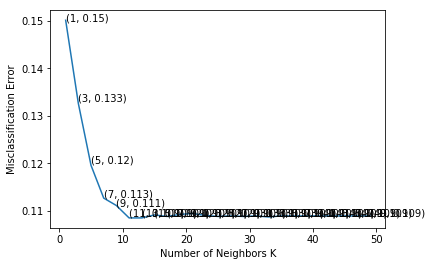

the misclassification error for each k value is :  [0.15  0.133 0.12  0.113 0.111 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]
Train accuracy 0.8969791666666667

The accuracy of the knn classifier for k = 11 is 89.300000%


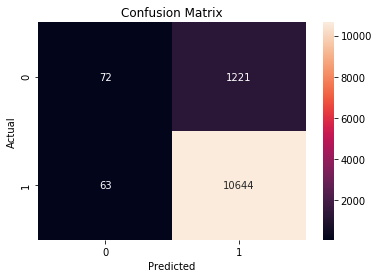

Confusion_mat:
 [[   72  1221]
 [   63 10644]]
F1 score:
 0.9431153641679957
Classification Report:
              precision    recall  f1-score   support

          0       0.53      0.06      0.10      1293
          1       0.90      0.99      0.94     10707

avg / total       0.86      0.89      0.85     12000



In [31]:
#calling the function KNN with brute algorithm
knn_brute(cv_bow,test_bow)


The optimal number of neighbors is 11.


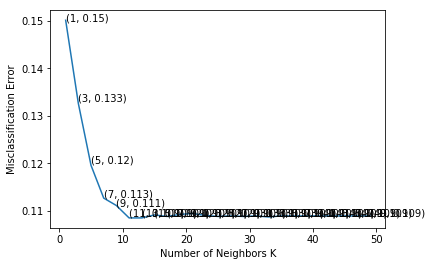

the misclassification error for each k value is :  [0.15  0.133 0.12  0.113 0.111 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]
Train accuracy 0.8969791666666667

The accuracy of the knn classifier for k = 11 is 89.300000%


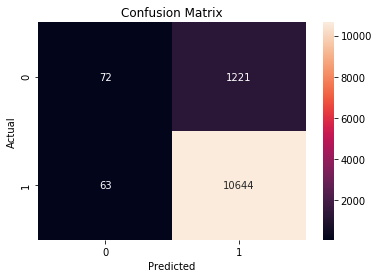

Confusion_mat:
 [[   72  1221]
 [   63 10644]]
F1 score:
 0.9431153641679957
Classification Report:
              precision    recall  f1-score   support

          0       0.53      0.06      0.10      1293
          1       0.90      0.99      0.94     10707

avg / total       0.86      0.89      0.85     12000



In [32]:
knn_kdtree(cv_bow,test_bow)

Observation: KNN with BoW

1. Of the 12000 test data points, there are 1293 negative reviews and 10707 positive reviews. 
2. From the confusion matrix, it can be found that out of 1293 negative reviews, 72 reviews are predicted as negative(True negative) and the remaining 1221 reviews are predicted as positive(False Positive). 
3. Similarly, out of 10707 positive reviews, 10644 reviews are predicted correctly as positive(True Positive) and the rest 63 are classified as negative reviews.
4. It can be said that KNN with BoW predicted positive reviews better than negative reviews.
5. Number of neighbors is found to be 11 and test accuracy is 89%.
6. Train and test accuracy looks almost same.


In [33]:
# Word2Vec model for train
i=0
list_of_sent=[]
for sent in X_tr['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(X_tr['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])


# Word2Vec model for test and CV
i=0
list_of_sent_cv=[]
for sent in X_cv['CleanedText'].values:
    list_of_sent_cv.append(sent.split())
    
print(X_cv['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])


i=0
list_of_sent_test=[]
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())
    
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

three dog like two quit picki enjoy research liter garbag goe dog food real find
*****************************************************************
['three', 'dog', 'like', 'two', 'quit', 'picki', 'enjoy', 'research', 'liter', 'garbag', 'goe', 'dog', 'food', 'real', 'find']
dont write mani review say kettl brand chip best ever tast everi flavor dynamit feel iffi honey dijon would recommend cheddar beer absolut amaz theyr healthi besid lil fat eaten lot chip day kettl take cake enjoy dont eat fast
*****************************************************************
['dont', 'write', 'mani', 'review', 'say', 'kettl', 'brand', 'chip', 'best', 'ever', 'tast', 'everi', 'flavor', 'dynamit', 'feel', 'iffi', 'honey', 'dijon', 'would', 'recommend', 'cheddar', 'beer', 'absolut', 'amaz', 'theyr', 'healthi', 'besid', 'lil', 'fat', 'eaten', 'lot', 'chip', 'day', 'kettl', 'take', 'cake', 'enjoy', 'dont', 'eat', 'fast']
bought bag parti didnt time toast pita saw gave tri prefect quick way stylish dip chi

In [34]:
w2v_model_train=Word2Vec(list_of_sent,min_count=5,size=50, workers=5)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=5)
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=5)


In [35]:
w2v_words = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8385
sample words  ['three', 'dog', 'like', 'two', 'quit', 'picki', 'enjoy', 'research', 'liter', 'garbag', 'goe', 'food', 'real', 'find', 'review', 'one', 'ive', 'written', 'without', 'act', 'sampl', 'said', 'product', 'person', 'would', 'involv', 'bar', 'away', 'year', 'old', 'long', 'enough', 'bite', 'almost', 'famili', 'kid', 'ador', 'similar', 'big', 'bird', 'earth', 'best', 'sunni', 'day', 'snack', 'appl', 'unit', 'pack', 'actual', 'found']


In [36]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 38400/38400 [00:44<00:00, 855.29it/s]


38400
50


100%|██████████| 12000/12000 [00:14<00:00, 837.94it/s]


12000
50


100%|██████████| 9600/9600 [00:10<00:00, 894.45it/s] 


9600
50



The optimal number of neighbors is 1.


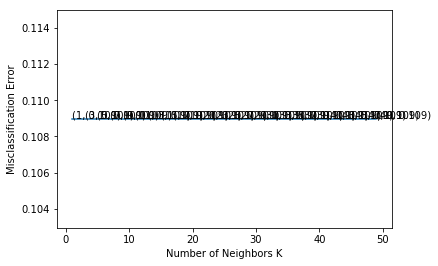

the misclassification error for each k value is :  [0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]
Train accuracy 0.8910416666666666

The accuracy of the knn classifier for k = 1 is 89.225000%


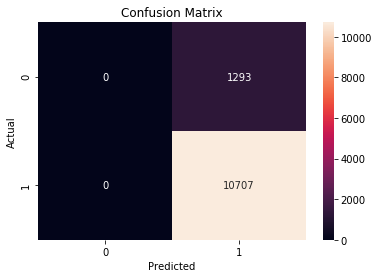

Confusion_mat:
 [[    0  1293]
 [    0 10707]]
F1 score:
 0.9430572070286696
Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1293
          1       0.89      1.00      0.94     10707

avg / total       0.80      0.89      0.84     12000



In [37]:
knn_brute(sent_vectors_cv,sent_vectors_test)


The optimal number of neighbors is 1.


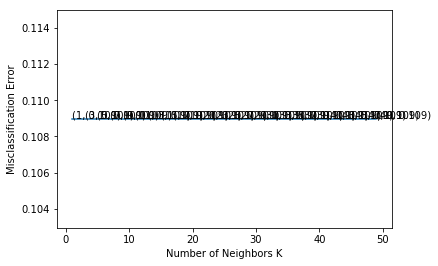

the misclassification error for each k value is :  [0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]
Train accuracy 0.8910416666666666

The accuracy of the knn classifier for k = 1 is 89.225000%


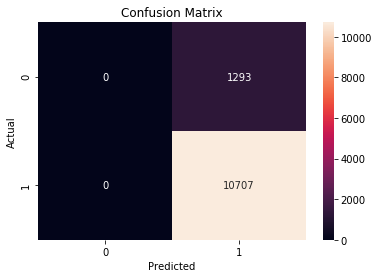

Confusion_mat:
 [[    0  1293]
 [    0 10707]]
F1 score:
 0.9430572070286696
Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1293
          1       0.89      1.00      0.94     10707

avg / total       0.80      0.89      0.84     12000



In [38]:
knn_kdtree(sent_vectors_cv,sent_vectors_test)

Observation: KNN with Average w2v model 
1. Both Brute and kd_tree alogorithm gives the same result.
2. From the confusion matrix, all 1293 negative reviews are incorrectly predicted as positive reviews and the remaining 10707 reviews are correctly predicted as positive reviews.
3. F1 score is 0 for negative reviews which means this model failed to classify negative reviews.
4. Number of neighbors is 1 and accuracy is 89.22%

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    
    
# TF-IDF weighted Word2Vec for test dataset
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
    
# TF-IDF weighted Word2Vec for cross validation dataset
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 9600/9600 [00:13<00:00, 706.53it/s]



The optimal number of neighbors is 17.


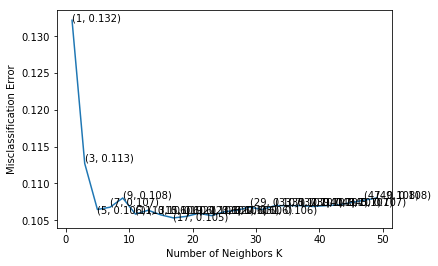

the misclassification error for each k value is :  [0.132 0.113 0.106 0.107 0.108 0.106 0.106 0.106 0.105 0.106 0.106 0.106
 0.106 0.106 0.107 0.106 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108
 0.108]
Train accuracy 0.8976041666666666

The accuracy of the knn classifier for k = 17 is 89.583333%


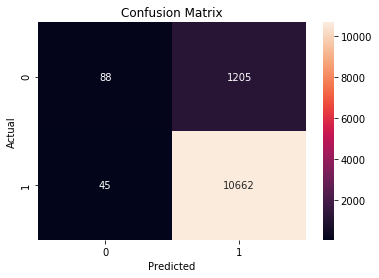

Confusion_mat:
 [[   88  1205]
 [   45 10662]]
F1 score:
 0.9446265615309648
Classification Report:
              precision    recall  f1-score   support

          0       0.66      0.07      0.12      1293
          1       0.90      1.00      0.94     10707

avg / total       0.87      0.90      0.86     12000



In [41]:
knn_brute(tfidf_sent_vectors_cv,tfidf_sent_vectors_test)



The optimal number of neighbors is 17.


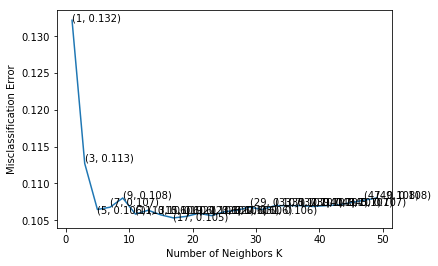

the misclassification error for each k value is :  [0.132 0.113 0.106 0.107 0.108 0.106 0.106 0.106 0.105 0.106 0.106 0.106
 0.106 0.106 0.107 0.106 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108
 0.108]
Train accuracy 0.8976041666666666

The accuracy of the knn classifier for k = 17 is 89.583333%


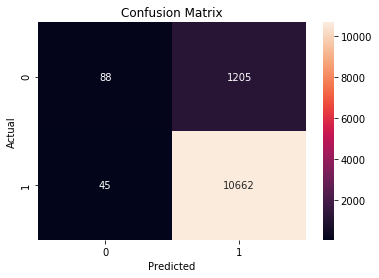

Confusion_mat:
 [[   88  1205]
 [   45 10662]]
F1 score:
 0.9446265615309648
Classification Report:
              precision    recall  f1-score   support

          0       0.66      0.07      0.12      1293
          1       0.90      1.00      0.94     10707

avg / total       0.87      0.90      0.86     12000



In [42]:
knn_kdtree(tfidf_sent_vectors_cv,tfidf_sent_vectors_test)

Observation: KNN with TFIDF w2v model 

1. From the confusion matrix, out of 1293 negative reviews, 1205 are correctly predicted as negative reviews and out of the 10707 positive reviews, 10662 reviews are correctly predicted as positive reviews.
2. F1 score is 0.12 for negative reviews and 0.94 for positive reviews.
3. Number of neighbors is 17 and test accuracy is 89.55%
    
    

In [8]:
from prettytable import PrettyTable
table = PrettyTable(["model","k","Train accuracy","Test accuracy"])
table.add_row(["KNN with BoW", "11", "89.69%","89.30"])
table.add_row(["KNN with TFIDF", "5", "91.62.69%","87.70"])
table.add_row(["KNN with Avg w2v", "1", "89.10%","89.22"])
table.add_row(["KNN with TFIDF weighted w2v", "17", "89.76%","89.58"])
print(table)

+-----------------------------+----+----------------+---------------+
|            model            | k  | Train accuracy | Test accuracy |
+-----------------------------+----+----------------+---------------+
|         KNN with BoW        | 11 |     89.69%     |     89.30     |
|        KNN with TFIDF       | 5  |   91.62.69%    |     87.70     |
|       KNN with Avg w2v      | 1  |     89.10%     |     89.22     |
| KNN with TFIDF weighted w2v | 17 |     89.76%     |     89.58     |
+-----------------------------+----+----------------+---------------+


Conclusion:

    Overall, feature to vectorization algorithm used above, number of nearest neighbors is less for BoW(k=11). Test accuracy: 89% for all the three vectorization techniques. There is a slight differenc in decimals.Both kd_tree and brute algorithm shows similar results in terms of accuracy.
    
    Based on the confusion matrix, it is better to go with TFIDF weighted w2v/BoW vectorization technique. Since, both models predicted the classification of positive and negative reviews in an acceptable way.
    Whereas, Average w2v model, the number of neighbors is 1 and also it predicted all the negative reviews as positive, which is not acceptable. Same scenario with TFIDF too(attached separate file)
    
    If we are much concerned about less k number of nearest neighbors, BoW stands out first(k=11) than TFIDF (k=17).
     
 